# Cross-subject encoding

Predicting each subject's activity using the synchronized activity of the other subjects. (Idk if any papers have done this, probably they have. Please someone lmk if they know of a reference.)

In [1]:
import re
import time
from collections import defaultdict
from pathlib import Path

import h5py
import numpy as np
import torch
from torch.utils.data import IterableDataset
from tqdm import tqdm

In [2]:
SUBJECTS = (1, 2, 3, 5)

In [3]:
root_dir = Path("..").resolve()

data_dir = root_dir / "algonauts_2025.competitors"

out_dir = Path(".") / "output/cross_encoding_v2"
out_dir.mkdir(exist_ok=True, parents=True)
print("Saving output to:", out_dir.resolve())

Saving output to: /home/connor/algonauts2025/cross_encoding/output/cross_encoding_v2


## Data loading

Aligned cross-subject fmri data loader. The data loader samples clips of synchronized activity from the same friends episodes across subjects. Each clip is shape `(n_subs, sample_length, dim)`.

We also load pre-extracted features of the shape `(sample_length, dim)`.

In [4]:
def parse_friends_run(run: str):
    match = re.match(r"s([0-9]+)e([0-9]+)([a-z])", run)
    if match is None:
        raise ValueError(f"Invalid friends run {run}")

    season = int(match.group(1))
    episode = int(match.group(2))
    part = match.group(3)
    return season, episode, part

In [5]:
class Algonauts2025FriendsFmri:
    def __init__(
        self,
        root: str | Path,
        subjects: list[int] | None = None,
        seasons: list[int] | None = None,
    ):
        self.root = root
        self.subjects = subjects or SUBJECTS
        self.seasons = seasons or list(range(1, 7))

        files = {
            sub: h5py.File(
                Path(root)
                / f"sub-{sub:02d}/func"
                / f"sub-{sub:02d}_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
            )
            for sub in self.subjects
        }

        episode_key_maps = defaultdict(dict)
        seasons_set = set(self.seasons)
        for sub, file in files.items():
            for key in file.keys():
                episode = key.split("-")[-1]  # 'ses-066_task-s06e24d'
                season, _, _ = parse_friends_run(episode)
                if season in seasons_set:
                    episode_key_maps[episode][sub] = key

        episode_list = sorted(
            [
                episode for episode, map in episode_key_maps.items()
                if len(map) == len(self.subjects)
            ]
        )

        data = {}
        for episode in episode_list:
            samples = []
            length = None
            for sub in self.subjects:
                key = episode_key_maps[episode][sub]
                sample = files[sub][key][:]
                sub_length = len(sample)
                samples.append(sample)
                length = min(length, sub_length) if length else sub_length
            data[episode] = np.stack([sample[:length] for sample in samples])

        self.episode_list = episode_list 
        self._data = data
    
    def get(self, episode: str) -> np.ndarray:
        return self._data[episode]

In [6]:
fmri_data = Algonauts2025FriendsFmri(
    root=data_dir / "fmri",
    seasons=range(1, 7),
)

In [7]:
sample = fmri_data.get("s01e05b")
print("Sample shape (NTC):", sample.shape, sample.dtype)

Sample shape (NTC): (4, 468, 1000) float32


In [28]:

class Algonauts2025FriendsDataset(IterableDataset):
    def __init__(
        self,
        fmri_data: Algonauts2025FriendsFmri,
        feat_data: list[dict[str, np.ndarray]] | None = None,
        seasons: list[int] | None = None,
        sample_length: int | None = 128,
        num_samples: int | None = None,
        shuffle: bool = True,
        seed: int | None = None,
    ):
        self.fmri_data = fmri_data
        self.feat_data = feat_data
        self.seasons = seasons or list(range(1, 7))

        episode_list = []
        seasons_set = set(self.seasons)
        for episode in fmri_data.episode_list:
            season, _, _ = parse_friends_run(episode)
            if season in seasons_set:
                episode_list.append(episode)
        self.episode_list = episode_list

        self.sample_length = sample_length
        self.num_samples = num_samples
        self.shuffle = shuffle
        self.seed = seed

        self._rng = np.random.default_rng(seed)
    
    def _iter_shuffle(self):
        sample_idx = 0
        while True:
            episode_order = self._rng.permutation(len(self.episode_list))

            for ii in episode_order:
                episode = self.episode_list[ii]
                fmri = torch.from_numpy(self.fmri_data.get(episode))

                if self.feat_data:
                    feats = [
                        torch.from_numpy(data.get(episode))
                        for data in self.feat_data
                    ]
                else:
                    feats = feat_samples = None

                # Nb, fmri and feature length often off by 1 or 2.
                # But assuming time locked to start.
                length = fmri.shape[1]
                if feats:
                    length = min(length, min(feat.shape[0] for feat in feats))

                if self.sample_length:
                    # Random segment of run
                    offset = int(self._rng.integers(0, length - self.sample_length + 1))
                    fmri_sample = fmri[:, offset: offset + self.sample_length]
                    if feats:
                        feat_samples = [
                            feat[offset: offset + self.sample_length] for feat in feats
                        ]
                else:
                    # Take full run
                    # Nb this only works for batch size 1 since runs are different length
                    fmri_sample = fmri[:, :length]
                    if feats:
                        feat_samples = [feat[:length] for feat in feats]

                if feat_samples:
                    yield episode, fmri_sample, feat_samples
                else:
                    yield episode, fmri_sample

                sample_idx += 1
                if self.num_samples and sample_idx >= self.num_samples:
                    return

    def _iter_ordered(self):
        sample_idx = 0
        for episode in self.episode_list:
            fmri = torch.from_numpy(self.fmri_data.get(episode))
            if self.feat_data:
                feats = [
                    torch.from_numpy(data.get(episode))
                    for data in self.feat_data
                ]
            else:
                feats = feat_samples = None

            length = fmri.shape[1]
            if feats:
                length = min(length, min(feat.shape[0] for feat in feats))

            sample_length = self.sample_length or length

            for offset in range(0, length - sample_length + 1, sample_length):
                fmri_sample = fmri[:, offset: offset + sample_length]
                if feats:
                    feat_samples = [feat[offset: offset + sample_length] for feat in feats]

                if feat_samples:
                    yield episode, fmri_sample, feat_samples
                else:
                    yield episode, fmri_sample

                sample_idx += 1
                if self.num_samples and sample_idx >= self.num_samples:
                    return

    def __iter__(self):
        if self.shuffle:
            yield from self._iter_shuffle()
        else:
            yield from self._iter_ordered()

In [29]:
dataset = Algonauts2025FriendsDataset(
    fmri_data,
    seasons=range(1, 6),
    sample_length=64,
    num_samples=10000,
    shuffle=True,
    seed=42,
)

In [30]:
total_bytes = 0
tic = time.monotonic()
for task, fmri_sample in tqdm(dataset):
    total_bytes += fmri_sample.numel() * 4
rt = time.monotonic() - tic
tput = total_bytes / 1024 ** 2 / rt 
print(f"run time={rt:.3f}s, MB/s={tput:.0f}")

10000it [00:00, 135387.04it/s]

run time=0.083s, MB/s=117803


## Model

Model architecture is a simple linear encoder and decoder for each subject. The encoder/decoder is "factorized" into a depthwise conv1d (to align data temporally), and a linear projection (to align data spatially).

For each subject, the input to the decoder is the average of the latents for the other three subjects.

In [12]:
from functools import partial

import torch
import torch.nn.functional as F
from torch import nn

In [13]:
class CausalConv1d(nn.Conv1d):
    """Conv1d layer with a causal mask, to only "attend" to past time points."""
    attn_mask: torch.Tensor

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: str | int = 0,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
    ):
        assert kernel_size % 2 == 1, "causal conv requires odd kernel size"
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )

        attn_mask = torch.zeros(kernel_size)
        attn_mask[:kernel_size // 2 + 1] = 1.0
        self.weight.data.mul_(attn_mask)
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        weight = self.weight * self.attn_mask
        return F.conv1d(
            input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

In [14]:
class ConvLinear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int = 11,
        causal: bool = False,
    ):
        super().__init__()
        conv_layer = CausalConv1d if causal else nn.Conv1d
        self.conv = conv_layer(
            in_features,
            in_features,
            kernel_size=kernel_size,
            padding="same",
            groups=in_features,
        )
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x: torch.Tensor):
        # x: (N, L, C)
        x = x.transpose(-1, -2)
        x = self.conv(x)
        x = x.transpose(-1, -2)
        x = self.fc(x)
        return x


class LinearConv(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int = 11,
        causal: bool = False,
    ):
        super().__init__()
        conv_layer = CausalConv1d if causal else nn.Conv1d
        self.fc = nn.Linear(in_features, out_features)
        self.conv = conv_layer(
            out_features,
            out_features,
            kernel_size=kernel_size,
            padding="same",
            groups=out_features,
        )

    def forward(self, x: torch.Tensor):
        # x: (N, L, C)
        x = self.fc(x)
        x = x.transpose(-1, -2)
        x = self.conv(x)
        x = x.transpose(-1, -2)
        return x

In [15]:
encoder = ConvLinear(
    in_features=1000,
    out_features=256,
    causal=True
)
print(encoder)

# (N, L, C)
x = torch.randn(16, 64, 1000)
embed = encoder.forward(x)
print(embed.shape)

ConvLinear(
  (conv): CausalConv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
  (fc): Linear(in_features=1000, out_features=256, bias=True)
)
torch.Size([16, 64, 256])


In [158]:
class CrossSubjectConvLinearEncoderV2(nn.Module):
    """
    - Minor refactoring
    - Added subject shared linear projections
    """
    weight: torch.Tensor

    def __init__(
        self,
        num_subjects: int = 4,
        fmri_dim: int = 1000,
        embed_dim: int = 256,
        kernel_size: int = 11,
        normalize: bool = False,
        with_shared_encoder: bool = True,
        with_shared_decoder: bool = True,
        with_subject_encoders: bool = True,
        with_subject_decoders: bool = True,
    ):
        super().__init__()
        assert with_shared_encoder or with_subject_encoders
        assert with_shared_decoder or with_subject_decoders

        self.num_subjects = num_subjects

        if with_shared_encoder:
            self.shared_encoder = nn.Linear(fmri_dim, embed_dim)
        else:
            self.register_module("shared_encoder", None)

        if with_subject_encoders:
            if kernel_size > 1:
                encoder_fn = partial(LinearConv, kernel_size=kernel_size)
            else:
                encoder_fn = nn.Linear
            self.subject_encoders = nn.ModuleList(
                [encoder_fn(fmri_dim, embed_dim) for _ in range(num_subjects)]
            )
        else:
            self.register_module("subject_encoders", None)

        self.norm = nn.LayerNorm(embed_dim) if normalize else nn.Identity()

        if with_shared_decoder:
            self.shared_decoder = nn.Linear(embed_dim, fmri_dim)
        else:
            self.register_module("shared_decoder", None)
        
        if with_subject_decoders:
            if kernel_size > 1:
                decoder_fn = partial(ConvLinear, kernel_size=kernel_size)
            else:
                decoder_fn = nn.Linear
            self.subject_decoders = nn.ModuleList(
                [decoder_fn(embed_dim, fmri_dim) for _ in range(num_subjects)]
            )
        else:
            self.register_module("subject_decoders", None)

        # todo: could learn the averaging weights
        weight = (1.0 - torch.eye(self.num_subjects)) / (self.num_subjects - 1.0)
        self.register_buffer("weight", weight)
        self.apply(init_weights)
    
    def forward(self, input: torch.Tensor):
        # input: (N, S, L, C)
        # subject specific encoders

        if self.shared_encoder is not None:
            shared_embed = self.shared_encoder(input)
        else:
            shared_embed = 0.0
        
        if self.subject_encoders is not None:
            subject_embeds = torch.stack(
                [encoder(input[:, ii]) for ii, encoder in enumerate(self.subject_encoders)],
                dim=1,
            )
        else:
            subject_embeds = 0.0

        embed = self.norm(shared_embed + subject_embeds)

        # average pool the latents for all but target subject
        embed = torch.einsum("nslc,ts->ntlc", embed, self.weight)

        # subject specific decoders
        if self.shared_decoder is not None:
            shared_output = self.shared_decoder(embed)
        else:
            shared_output = 0.0
        
        if self.subject_decoders is not None:
            subject_outputs = torch.stack(
                [decoder(embed[:, ii]) for ii, decoder in enumerate(self.subject_decoders)],
                dim=1,
            )
        else:
            subject_outputs = 0.0
        output = shared_output + subject_outputs
        return output
    

def init_weights(m: nn.Module):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
        nn.init.trunc_normal_(m.weight, std=0.02)
        nn.init.constant_(m.bias, 0)

In [159]:
cross_encoder = CrossSubjectConvLinearEncoderV2()
print(cross_encoder)

# (N, S, L, C)
x = torch.randn(16, 4, 64, 1000)
z = cross_encoder.forward(x)
print(z.shape)

CrossSubjectConvLinearEncoderV2(
  (shared_encoder): Linear(in_features=1000, out_features=256, bias=True)
  (subject_encoders): ModuleList(
    (0-3): 4 x LinearConv(
      (fc): Linear(in_features=1000, out_features=256, bias=True)
      (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=same, groups=256)
    )
  )
  (norm): Identity()
  (shared_decoder): Linear(in_features=256, out_features=1000, bias=True)
  (subject_decoders): ModuleList(
    (0-3): 4 x ConvLinear(
      (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=same, groups=256)
      (fc): Linear(in_features=256, out_features=1000, bias=True)
    )
  )
)
torch.Size([16, 4, 64, 1000])


## Training

Basic training loop, AdamW, no lr decay, no bells and whistles.

In [18]:
import math

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from timm.utils import AverageMeter, random_seed

In [19]:
def train_one_epoch(
    *,
    epoch: int,
    model: torch.nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch_batches: int | None,
    device: torch.device,
):
    model.train()
    
    use_cuda = device.type == "cuda"
    if use_cuda:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    loss_m = AverageMeter()
    data_time_m = AverageMeter()
    step_time_m = AverageMeter()

    epoch_batches = len(train_loader) if epoch_batches is None else epoch_batches
    first_step = epoch * epoch_batches

    end = time.monotonic()
    for batch_idx, (_, sample) in enumerate(train_loader):
        step = first_step + batch_idx
        sample = sample.to(device)
        batch_size = sample.size(0)
        data_time = time.monotonic() - end

        # forward pass
        output = model(sample)
        loss = F.mse_loss(output, sample)
        loss_item = loss.item()

        if math.isnan(loss_item) or math.isinf(loss_item):
            raise RuntimeError("NaN/Inf loss encountered on step %d; exiting", step)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # end of iteration timing
        if use_cuda:
            torch.cuda.synchronize()
        step_time = time.monotonic() - end

        loss_m.update(loss_item, batch_size)
        data_time_m.update(data_time, batch_size)
        step_time_m.update(step_time, batch_size)

        if step % 10 == 0:
            tput = batch_size / step_time_m.avg
            if use_cuda:
                alloc_mem_gb = torch.cuda.max_memory_allocated() / 1e9
                res_mem_gb = torch.cuda.max_memory_reserved() / 1e9
            else:
                alloc_mem_gb = res_mem_gb = 0.0

            print(
                f"Train: {epoch:>3d} [{batch_idx:>3d}/{epoch_batches}][{step:>6d}]"
                f"  Loss: {loss_m.val:#.3g} ({loss_m.avg:#.3g})"
                f"  Time: {data_time_m.avg:.3f},{step_time_m.avg:.3f} {tput:.0f}/s"
                f"  Mem: {alloc_mem_gb:.2f},{res_mem_gb:.2f} GB"
            )

        # Restart timer for next iteration
        end = time.monotonic()

In [20]:
@torch.no_grad()
def validate(
    *,
    epoch: int,
    model: torch.nn.Module,
    val_loader: DataLoader,
    device: torch.device,
):
    model.eval()

    use_cuda = device.type == "cuda"

    loss_m = AverageMeter()
    data_time_m = AverageMeter()
    step_time_m = AverageMeter()

    samples = []
    outputs = []

    end = time.monotonic()
    for batch_idx, (_, sample) in enumerate(val_loader):
        sample = sample.to(device)
        batch_size = sample.size(0)
        data_time = time.monotonic() - end

        # forward pass
        output = model(sample)
        loss = F.mse_loss(output, sample)
        loss_item = loss.item()

        # end of iteration timing
        if use_cuda:
            torch.cuda.synchronize()
        step_time = time.monotonic() - end

        loss_m.update(loss_item, batch_size)
        data_time_m.update(data_time, batch_size)
        step_time_m.update(step_time, batch_size)

        N, S, L, C = sample.shape
        assert N, S == (1, 4)
        samples.append(sample.cpu().numpy().swapaxes(0, 1).reshape((S, N*L, C)))
        outputs.append(output.cpu().numpy().swapaxes(0, 1).reshape((S, N*L, C)))

        # Reset timer
        end = time.monotonic()

    # (S, N, C)
    samples = np.concatenate(samples, axis=1)
    outputs = np.concatenate(outputs, axis=1)

    metrics = {}

    # Encoding accuracy metrics
    dim = samples.shape[-1]
    acc = 0.0
    acc_map = np.zeros(dim)
    for ii, sub in enumerate(SUBJECTS):
        y_true = samples[ii].reshape(-1, dim)
        y_pred = outputs[ii].reshape(-1, dim)
        metrics[f"acc_map_sub-{sub}"] = acc_map_i = pearsonr_score(y_true, y_pred)
        metrics[f"acc_sub-{sub}"] = acc_i = np.mean(acc_map_i)
        acc_map += acc_map_i / len(SUBJECTS)
        acc += acc_i / len(SUBJECTS)

    metrics["acc_map_avg"] = acc_map
    metrics["acc_avg"] = acc
    accs_fmt = ",".join(
        f"{val:.3f}" for key, val in metrics.items() if key.startswith("acc_sub-")
    )

    tput = batch_size / step_time_m.avg
    print(
        f"Val: {epoch:>3d}"
        f"  Loss: {loss_m.avg:#.3g}"
        f"  Acc: {accs_fmt} ({acc:.3f})"
        f"  Time: {data_time_m.avg:.3f},{step_time_m.avg:.3f} {tput:.0f}/s"
    )

    return acc, metrics


def pearsonr_score(
    y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7
) -> np.ndarray:
    assert y_true.ndim == y_pred.ndim == 2

    y_true = y_true - y_true.mean(axis=0)
    y_true = y_true / (np.linalg.norm(y_true, axis=0) + eps)

    y_pred = y_pred - y_pred.mean(axis=0)
    y_pred = y_pred / (np.linalg.norm(y_pred, axis=0) + eps)

    score = (y_true * y_pred).sum(axis=0)
    return score

In [227]:
seed = 3315
batch_size = 16
sample_length = 64
n_train_samples = 2000
embed_dim = 128
kernel_size = 7
lr = 3e-4
weight_decay = 0.001
epochs = 10

with_shared = True
with_subject = True

In [228]:
random_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [229]:
train_dataset = Algonauts2025FriendsDataset(
    fmri_data=fmri_data,
    seasons=range(1, 6),
    sample_length=sample_length,
    num_samples=n_train_samples,
    shuffle=True,
    seed=42,
)

val_dataset = Algonauts2025FriendsDataset(
    fmri_data=fmri_data,
    seasons=[6],
    sample_length=None,
    shuffle=False,
)

In [230]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=1)

In [231]:
_, sample = next(iter(train_loader))
print("Sample shape:", tuple(sample.shape))

Sample shape: (16, 4, 64, 1000)


In [232]:
model = CrossSubjectConvLinearEncoderV2(
    embed_dim=embed_dim,
    kernel_size=kernel_size,
    with_shared_encoder=with_shared,
    with_shared_decoder=with_shared,
    with_subject_encoders=with_subject,
    with_subject_decoders=with_subject,
)
model = model.to(device)

param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model:", model)
print(f"Num params: {param_count/1e6:.2f}M")

Model: CrossSubjectConvLinearEncoderV2(
  (shared_encoder): Linear(in_features=1000, out_features=128, bias=True)
  (subject_encoders): ModuleList(
    (0-3): 4 x LinearConv(
      (fc): Linear(in_features=1000, out_features=128, bias=True)
      (conv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same, groups=128)
    )
  )
  (norm): Identity()
  (shared_decoder): Linear(in_features=128, out_features=1000, bias=True)
  (subject_decoders): ModuleList(
    (0-3): 4 x ConvLinear(
      (conv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same, groups=128)
      (fc): Linear(in_features=128, out_features=1000, bias=True)
    )
  )
)
Num params: 1.29M


In [233]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
epoch_batches = n_train_samples // batch_size

In [234]:
for epoch in range(epochs):
    train_one_epoch(
        epoch=epoch,
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        epoch_batches=epoch_batches,
        device=device,
    )
    acc, metrics = validate(
        epoch=epoch,
        model=model,
        val_loader=val_loader,
        device=device,
    )

Train:   0 [  0/125][     0]  Loss: 0.362 (0.362)  Time: 0.013,0.074 216/s  Mem: 0.15,0.20 GB
Train:   0 [ 10/125][    10]  Loss: 0.358 (0.368)  Time: 0.009,0.029 551/s  Mem: 0.17,0.23 GB
Train:   0 [ 20/125][    20]  Loss: 0.340 (0.363)  Time: 0.007,0.023 710/s  Mem: 0.17,0.23 GB
Train:   0 [ 30/125][    30]  Loss: 0.346 (0.357)  Time: 0.006,0.019 841/s  Mem: 0.17,0.23 GB
Train:   0 [ 40/125][    40]  Loss: 0.348 (0.354)  Time: 0.006,0.017 922/s  Mem: 0.17,0.23 GB
Train:   0 [ 50/125][    50]  Loss: 0.351 (0.351)  Time: 0.006,0.016 970/s  Mem: 0.17,0.23 GB
Train:   0 [ 60/125][    60]  Loss: 0.323 (0.348)  Time: 0.006,0.016 1004/s  Mem: 0.17,0.23 GB
Train:   0 [ 70/125][    70]  Loss: 0.330 (0.345)  Time: 0.006,0.016 1028/s  Mem: 0.17,0.23 GB
Train:   0 [ 80/125][    80]  Loss: 0.332 (0.343)  Time: 0.005,0.015 1068/s  Mem: 0.17,0.23 GB
Train:   0 [ 90/125][    90]  Loss: 0.326 (0.342)  Time: 0.005,0.015 1093/s  Mem: 0.17,0.23 GB
Train:   0 [100/125][   100]  Loss: 0.328 (0.340)  Time:

## Results

### Initial run, same hparams as before

```python
seed = 3315
batch_size = 16
sample_length = 64
n_train_samples = 2000
embed_dim = 256
kernel_size = 11
lr = 3e-4
weight_decay = 0.001
epochs = 10
```

```
Val:   9  Loss: 0.314  Acc: 0.351,0.351,0.376,0.321 (0.350)  Time: 0.004,0.006 166/s
```

### Smaller bottleneck embed dim


```python
embed_dim = 128
```

```
Val:   9  Loss: 0.313  Acc: 0.351,0.352,0.377,0.323 (0.351)  Time: 0.002,0.003 306/s
```

```python
embed_dim = 64
```

```
Val:   9  Loss: 0.314  Acc: 0.348,0.350,0.375,0.322 (0.349)  Time: 0.003,0.006 181/s
```

```python
embed_dim = 32
```

```
Val:   9  Loss: 0.315  Acc: 0.343,0.344,0.369,0.318 (0.344)  Time: 0.003,0.006 175/s
```

```python
embed_dim = 16
```

```
Val:   9  Loss: 0.318  Acc: 0.332,0.335,0.358,0.309 (0.333)  Time: 0.004,0.006 177/s
```

```python
embed_dim = 8
```

```
Val:   9  Loss: 0.325  Acc: 0.307,0.312,0.329,0.288 (0.309)  Time: 0.004,0.006 172/s
```

```python
embed_dim = 4
```

```
Val:   9  Loss: 0.333  Acc: 0.270,0.276,0.293,0.258 (0.274)  Time: 0.002,0.003 301/s
```

```python
embed_dim = 2
```

```
Val:   9  Loss: 0.344  Acc: 0.217,0.225,0.231,0.209 (0.221)  Time: 0.003,0.005 201/s
```

So even with only 8 dimension, predict r>0.3. Does not bode well for rich signal in these data..

### Varying kernel size

Otherwise all params as default except

```
embed_dim = 128
```

```
kernel_size = 17
```

```
Val:   9  Loss: 0.313  Acc: 0.351,0.352,0.376,0.322 (0.350)  Time: 0.002,0.003 329/s
```

```
kernel_size = 5
```

```
Val:   9  Loss: 0.313  Acc: 0.351,0.350,0.378,0.323 (0.351)  Time: 0.003,0.006 177/s
```

```
kernel_size = 3
```

```
Val:   9  Loss: 0.313  Acc: 0.350,0.348,0.376,0.322 (0.349)  Time: 0.003,0.006 181/s
```

```
kernel_size = 0
```

```
Val:   9  Loss: 0.316  Acc: 0.341,0.340,0.365,0.312 (0.339)  Time: 0.003,0.004 228/s
```

Interesting, the temporal alignment only has a fairly small effect.


### Removing shared/subject components

Otherwise all params as default except

```
embed_dim = 128
kernel_size = 7
```

```
with_shared = True
with_subject = True
```

```
Val:   9  Loss: 0.313  Acc: 0.351,0.351,0.377,0.324 (0.351)  Time: 0.003,0.005 186/s
```


```
with_shared = False
with_subject = True
```

```
Val:   9  Loss: 0.315  Acc: 0.343,0.344,0.370,0.318 (0.344)  Time: 0.002,0.003 318/s
```

```
with_shared = True
with_subject = False
```

```
Val:   9  Loss: 0.326  Acc: 0.310,0.304,0.332,0.282 (0.307)  Time: 0.002,0.002 439/s
```

Interesting, still r>0.3 for weak baseline of shared pca only...

### Varying optimization

```
epochs = 20
```

```
Val:  19  Loss: 0.315  Acc: 0.350,0.348,0.369,0.316 (0.346)  Time: 0.003,0.006 169/s
```

```
lr = 1e-3
```

```
Val:   9  Loss: 0.317  Acc: 0.345,0.346,0.364,0.308 (0.341)  Time: 0.005,0.008 133/s
```

```
lr = 1e-4
```

```
Val:   9  Loss: 0.316  Acc: 0.342,0.341,0.367,0.316 (0.341)  Time: 0.003,0.005 215/s
```


### Final saved config

```python
seed = 3315
batch_size = 16
sample_length = 64
n_train_samples = 2000
embed_dim = 128
kernel_size = 7
lr = 3e-4
weight_decay = 0.001
epochs = 10

with_shared = True
with_subject = True
```

```
Val:   9  Loss: 0.313  Acc: 0.351,0.351,0.377,0.324 (0.351)  Time: 0.002,0.003 311/s
```


In [237]:
with open(out_dir / "ckpt.pt", "wb") as f:
    torch.save(
        {
            "model": model.state_dict(),
            "metrics": metrics,
            "acc": acc,
        },
        f,
    )

In [259]:
ckpt = torch.load(out_dir / "ckpt.pt", map_location=device, weights_only=False)
metrics = ckpt["metrics"]
acc = ckpt["acc"]
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
for key, val in metrics.items():
    if key.startswith("acc_map"):
        np.save(out_dir / f"cross_enc_{key}.npy", val)

acc_map_sub-1 (1000,)
acc_map_sub-2 (1000,)
acc_map_sub-3 (1000,)
acc_map_sub-5 (1000,)
acc_map_avg (1000,)


## Analysis

### Glass brain encoding accuracy

In [241]:
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nib
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

In [249]:
atlas_path = root_dir / "resources/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"
atlas = nib.load(atlas_path)

atlas_masker = NiftiLabelsMasker(atlas)
atlas_masker.fit()

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x7fe59633db20>,
                  memory=Memory(location=None))

In [250]:
def plot_encoding_accuracy(masker: NiftiLabelsMasker, acc_map: np.ndarray, sub: int, **kwargs):
    acc_vol = masker.inverse_transform(acc_map)
    acc = np.mean(acc_map)
    title = f"Cross encoding accuracy, sub-{sub:02d}, mean accuracy: {acc:.3f}"

    display = plotting.plot_glass_brain(
        acc_vol,
        display_mode="lyrz",
        cmap="hot_r",
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        title=title,
        **kwargs,
    )
    colorbar = display._cbar
    colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)

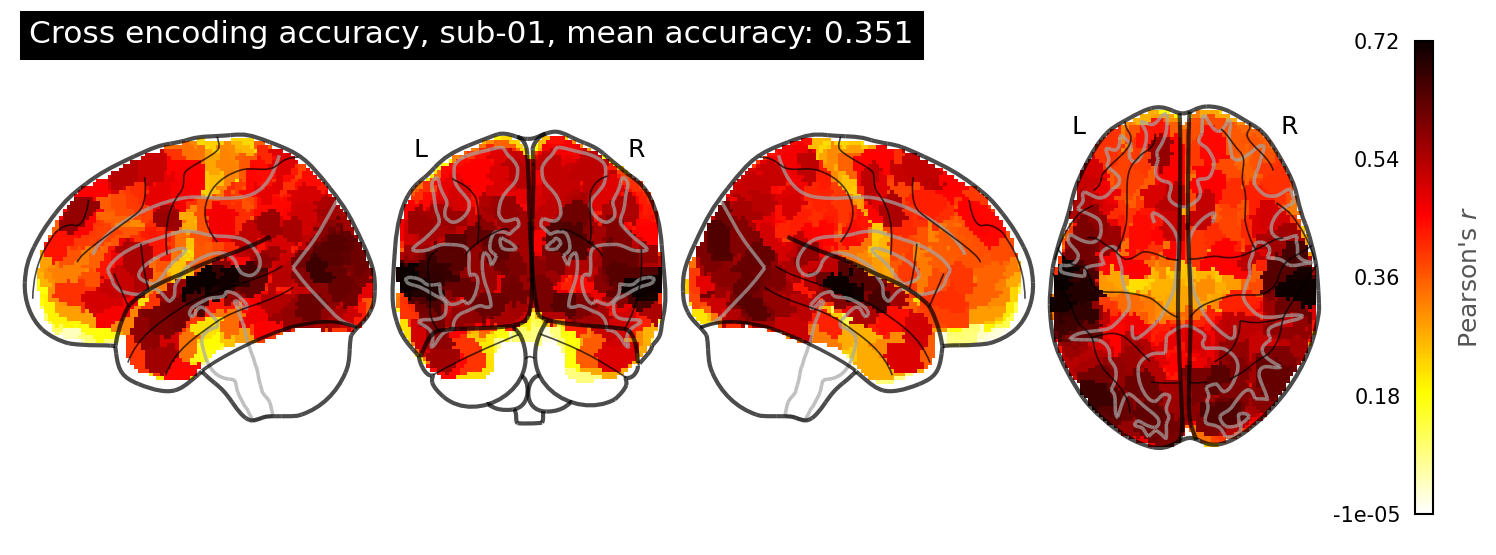

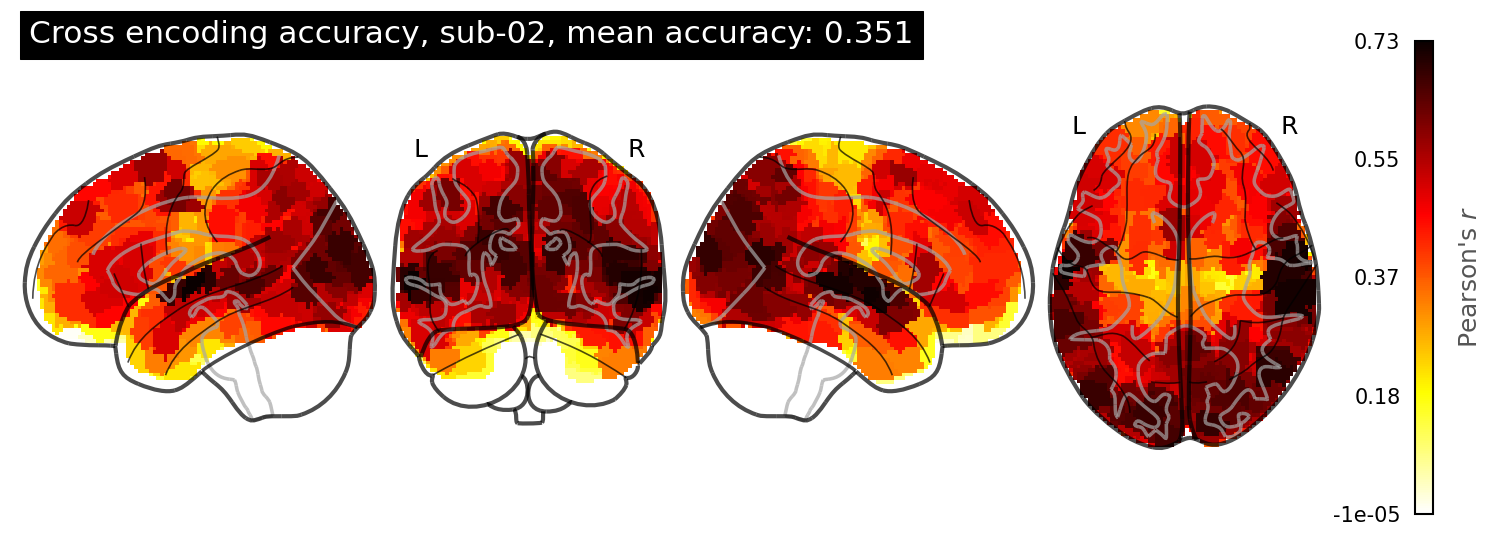

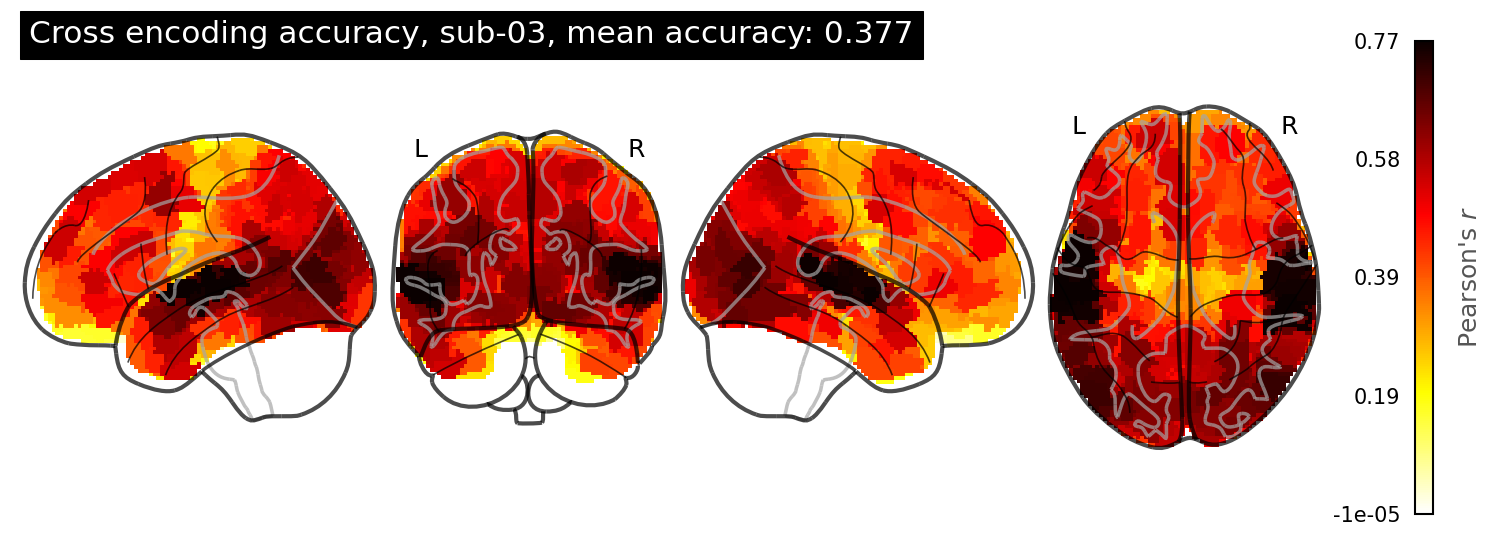

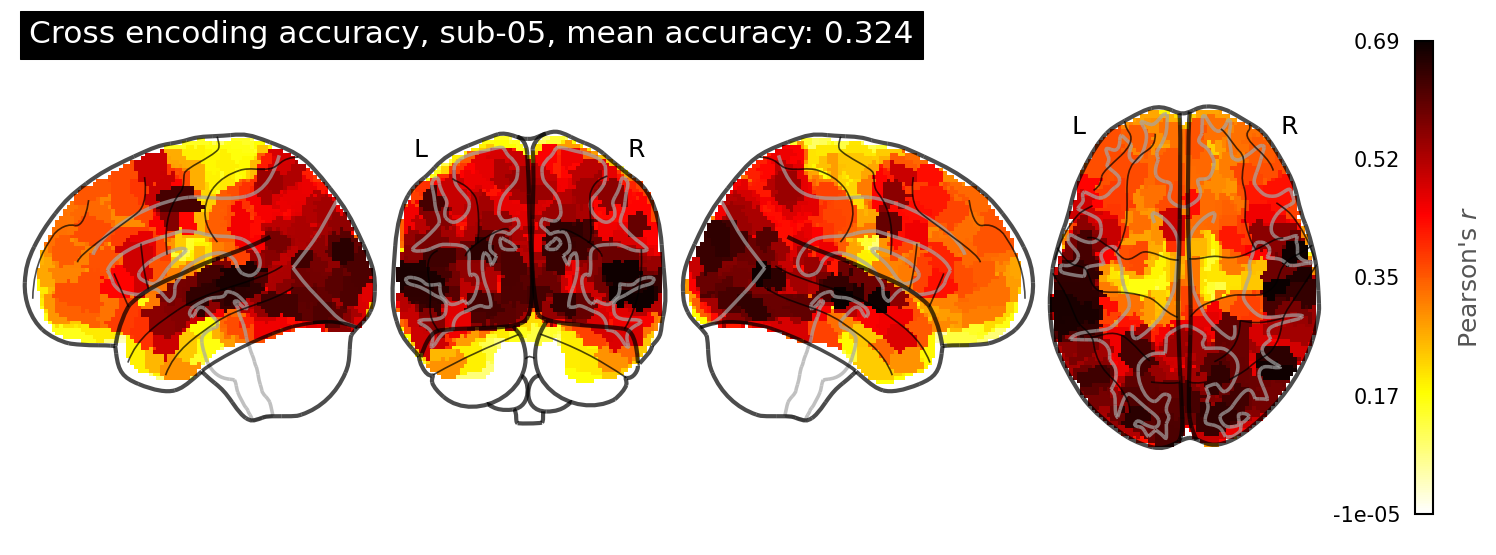

In [251]:
for sub in SUBJECTS:
    plot_encoding_accuracy(atlas_masker, metrics[f"acc_map_sub-{sub}"], sub, vmin=0.0)
    plt.savefig(out_dir / f"cross_enc_acc_glass_brain_sub-{sub}.png")

### Flat map encoding accuracy

In [252]:
import nibabel as nib
from nisc.surface import load_flat
from nisc.resample import Resampler
from nisc.cifti import get_cifti_surf_data
from matplotlib import pyplot as plt

In [253]:
# Settings for flat map
PIXEL_SIZE = 2.0
RECT = (-314.0, 324.0, -138.0, 148.0)

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

In [254]:
def load_resampler_parc() -> tuple[Resampler, np.ndarray]:
    parc = get_cifti_surf_data(
        nib.load(root_dir / "resources/Schaefer2018_1000Parcels_7Networks_order.dscalar.nii")
    )
    parc = parc.flatten()

    mask = parc > 0
    flat = load_flat("32k_fs_LR")
    flat = flat.extract_patch(mask=mask)

    resampler = Resampler(pixel_size=PIXEL_SIZE, rect=RECT)
    resampler.fit(flat.points)

    parc_flat = resampler.transform(parc[mask], categorical=True)

    N, P = int(resampler.mask_.sum()), int(parc.max())
    parc_one_hot = np.zeros((N, P))
    parc_indices = parc_flat[resampler.mask_].astype(np.int64) - 1
    parc_one_hot[np.arange(N), parc_indices] = 1.0
    return resampler, parc_one_hot

In [255]:
resampler, parc_one_hot = load_resampler_parc()

In [256]:
def map_to_flat(
    resampler: Resampler,
    parc_one_hot: np.ndarray,
    data: np.ndarray,
):
    assert data.ndim == 1
    H, W = resampler.mask_.shape
    flat_data = np.full((H, W), fill_value=np.nan, dtype=data.dtype)
    flat_data[resampler.mask_] = parc_one_hot @ data
    return flat_data

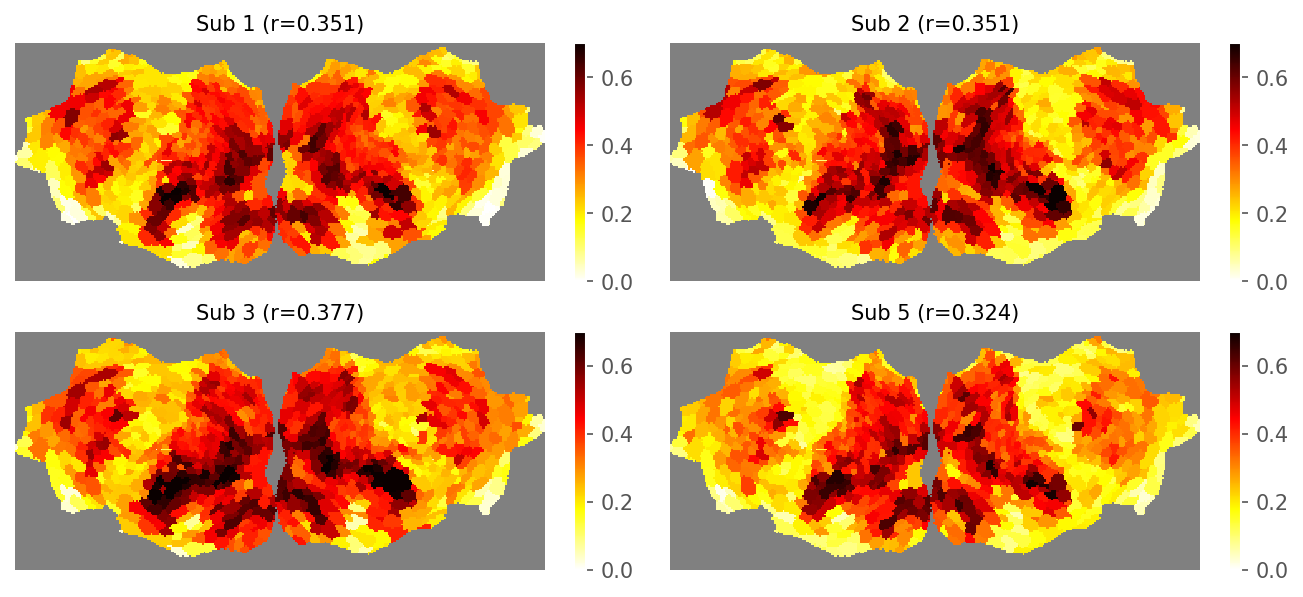

In [257]:
cmap = plt.get_cmap("hot_r")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 2
nc = 2

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii, sub in enumerate(SUBJECTS):
    plt.sca(axs[ii])

    acc = metrics[f"acc_sub-{sub}"]
    acc_flat = map_to_flat(resampler, parc_one_hot, metrics[f"acc_map_sub-{sub}"])

    plt.imshow(acc_flat, cmap=cmap, interpolation="nearest", vmin=0.0, vmax=0.7)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Sub {sub} (r={acc:.3f})", fontsize="medium")

plt.tight_layout()
plt.savefig(out_dir / "cross_enc_acc_flat_map.png")